In [1]:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension

2022-07-04 16:33:18.942211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 16:33:18.942228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


 # Loading respective PTA files

In [2]:
#All PTA Datasets are available at 
#https://drive.google.com/drive/folders/1Wy3NcSQBWanafkTBbHFzqPv-3Kg1pjMx?usp=sharing
Ae,ge=np.loadtxt('original/epta.csv').transpose()
Ap,gp=np.loadtxt('original/ppta.csv').transpose()
An,gn=np.loadtxt('original/ng.csv').transpose()
Ai,gi=np.loadtxt('original/ipta.csv').transpose()

In [3]:
names = ['logA','gamma']
names2=['EPTA','PPTA','NG12.5','IPTA']
del_names=['delta_logA','delta_gamma']
epta=MCSamples(samples=np.array([Ae,ge]).transpose(),label='EPTA',names = names)
ppta=MCSamples(samples=np.array([Ap,gp]).transpose(),label='PPTA',names = names)
ng=MCSamples(samples=np.array([An,gn]).transpose(),label='NG12.5',names = names)
ipta=MCSamples(samples=np.array([Ai,gi]).transpose(),label='IPTA',names = names)

epta_arr=[Ae,ge];ppta_arr=[Ap,gp];ng_arr=[An,gn];ipta_arr=[Ai,gi]
arr=[epta_arr,ppta_arr,ng_arr,ipta_arr]


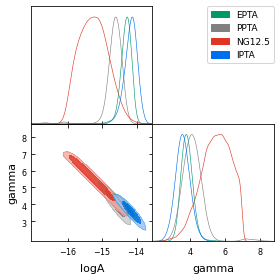

In [29]:
g = plots.get_subplot_plotter()
g.triangle_plot([epta,ppta,ng,ipta], filled=True)
plt.savefig('PTAcomparison.pdf',dpi=1000)

# I am getting errors while loading original chains!

In [5]:
mcmc_tension.n_threads = 1
# create the distribution of the parameter differences:
diff_chain = mcmc_tension.parameter_diff_chain( epta, ipta, boost=1 )

WeightedSampleError: Samples were not combined from separate chains

# For getting the distribution function of difference between chains I am assuming Gaussianity

In [19]:
def Diff_chain(A1,A2):
    Ae,ge=A1
    Ap,gp=A2
    mean_1=np.array([np.mean(Ae),np.mean(ge)])
    mean_2=np.array([np.mean(Ap),np.mean(gp)])
    diff_mean  = mean_1 -mean_2
    diff_cov=np.cov([Ae,ge])+np.cov([Ap,gp])
    diff_samps = np.random.multivariate_normal( diff_mean, diff_cov,size=int((len(Ae)+len(Ap))/2))
    diff_chain = MCSamples( samples = diff_samps,names = del_names)
    chi2_probability = scipy.stats.chi2.cdf(np.dot(np.dot( diff_mean, utilities.QR_inverse(diff_cov) ), diff_mean ), 2 )
    shift_probability, shift_lower, shift_upper = mcmc_tension.kde_parameter_shift_2D_fft(diff_chain, feedback=0)
    return diff_chain, shift_probability, shift_lower, shift_upper

In [22]:
A=[[],[],[],[],[],[]]
C1=[[],[],[],[],[],[]]
count=0
for i in range(4):
    for j in range(i+1,4):
        #print('Compare '+str(names2[i])+' & '+str(names2[j])+':')
        chain,val,lv,fv=Diff_chain(arr[i],arr[j])
        A[count].append(chain)
        
        A[count][0].updateSettings({'contours': [0.68, 0.95, val]})
        C1[count].append(str(names2[i])+' & '+str(names2[j]))
        count+=1

B,C=[],[]
for i in range(6):
    B.append(A[i][0])
    C.append(C1[i][0])

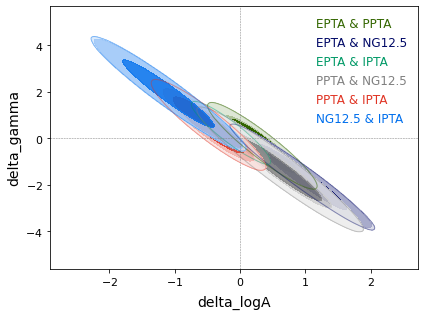

In [33]:
g = plots.get_single_plotter()
g.settings.num_plot_contours = 3
g.plot_2d(B,'delta_logA','delta_gamma', filled=True);
g.add_legend(C, colored_text=True);
g.add_x_marker(0)
g.add_y_marker(0)
plt.savefig('diff.jpg',dpi=1000)

In [26]:
data=np.zeros((4,4),dtype=object)

for i in range(4):
    for j in range(i+1,4):
        
        data[i][j]="{:.3f}".format(utilities.from_confidence_to_sigma(Diff_chain(arr[i],arr[j])[1]))
        
        
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of disagreement in 'r'$\sigma$:')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,1.177,1.829,0.217
PPTA,-,-,0.715,1.434
NANOGrav,-,-,-,2.091
IPTA,-,-,-,-


In [27]:
data=np.zeros((4,4),dtype=object)

for i in range(4):
    for j in range(i+1,4):
        
        data[i][j]="{:.3f}".format(Diff_chain(arr[i],arr[j])[1])
        
        
    for j in range(0,i+1):
        data[i][j]='-'
        
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of disagreement in Probablity')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,0.762,0.932,0.178
PPTA,-,-,0.529,0.846
NANOGrav,-,-,-,0.963
IPTA,-,-,-,-


In [30]:
data=np.zeros((4,4),dtype=object)

for i in range(4):
    for j in range(i+1,4):
        
        data[i][j]="{:.3f}".format(utilities.from_confidence_to_sigma(1-Diff_chain(arr[i],arr[j])[1]))
        
        
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of agreement in 'r'$\sigma$:')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,0.310,0.086,1.401
PPTA,-,-,0.631,0.193
NANOGrav,-,-,-,0.047
IPTA,-,-,-,-


In [31]:
data=np.zeros((4,4),dtype=object)

for i in range(4):
    for j in range(i+1,4):
        
        data[i][j]="{:.3f}".format(1-Diff_chain(arr[i],arr[j])[1])
        
        
    for j in range(0,i+1):
        data[i][j]='-'
        
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of agreement in Probablity')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,0.238,0.069,0.833
PPTA,-,-,0.474,0.154
NANOGrav,-,-,-,0.037
IPTA,-,-,-,-
